## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Preprocessing and training data development](#4_Preprocessing_and_training_data_development)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports](#4.3_Imports)
  * [4.4 Load The Cleaned Loan Data and Preprocess](#4.4_Load_The_Cleaned_Loan_Data_and_Preprocess)
    * [4.4.1 Loan Data](#4.4.1_Loan_Data)
    * [4.4.2 Compute MSA/non-MSA feature](#4.4.2_Compute_MSA/non-MSA_feature)
    * [4.4.3 Drop unneeded column attributes](#4.4.3_Drop_unneeded_column_attributes)
    * [4.4.4 Encode Categorical Variables](#4.4.4_Encode_Categorical_Variables)
    * [4.4.5 Split data into train and test](#4.4.5_Split_data_into_train_and_test)    
    * [4.4.6 Compute default rates by state and servicer](#4.4.6_Compute_default_rates_by_state_and_servicer) 
  * [4.5 Evaluate Standard Classification implementation using Random Forest](#4.5_Evaluate_Standard_Classification_implementation_using_Random_Forest)
    * [4.5.1 Random Forest Model](#4.5.1_Random_Forest_Model)
    * [4.5.2 Random Forest Model using SMOTE to handle imbalanced data](#4.5.2_Random_Forest_Model_using_SMOTE_to_handle_imbalanced_data)
  * [4.6 Cox model implementation](#4.6_Cox_model_implementation)
    * [4.6.1 Update target to include loan age/duration feature ](#4.6.1_Update_target_to_include_loan_age/duration_feature)
    * [4.6.2 Cox model](#4.6.2_Cox_model)
    * [4.6.3 Cox model with scaled data](#4.6.3_Cox_model_with_scaled_data)
  * [4.7 Setup model pipeline](#4.7_Setup_model_pipeline)
  * [4.8 Summary](#4.8_Summary)

## 4.2 Introduction<a id='4.2_Introduction'></a>

The preprocessing and training data step for the loan prediction problem will focus on preparing the loan training data, features, target variables, and implement Cox survival model.

## 4.3 Imports<a id='4.3_Imports'></a>

In [680]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing 
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

## 4.4 Load The Cleaned Loan Data and Preprocess<a id='4.4_Load_The_Cleaned_Loan_Data_and_Preprocess'></a>

In [681]:
dtype={"Credit_Score": int, 'First_Payment_Date':str, 'First_Time_Homebuyer_Flag':str,
       'Maturity_Date':str,
       'Metropolitan_Statistical_Area_(MSA)_Or_Metropolitan_Division':int,
       'Mortgage_Insurance_Percentage_(MI_%)':float, 'Number_of_Units':int,
       'Occupancy_Status':str, 'Original_Combined_Loan-to-Value_(CLTV)':float,
       'Original_Debt-to-Income_(DTI)_Ratio':float, 'Original_UPB':float,
       'Original_Loan-to-Value_(LTV)':float, 'Original_Interest_Rate':float, 'Channel':str,
       'Prepayment_Penalty_Mortgage_(PPM)_Flag':str, 'Property_State':str,
       'Property_Type':str, 'Postal_Code':str, 'Loan_Sequence_Number':str, 'Loan_Purpose':str,
       'Original_Loan_Term':int, 'Number_of_Borrowers':int, 'Seller_Name':str,
       'Servicer_Name':str, 'HARP_Indicator':str, 'Interest_Only_(I/O)_Indicator':str,
       'Monthly_Reporting_Period':str, 'Current_Actual_UPB':float,
       'Current_Loan_Delinquency_Status':str, 'Loan_Age':int,
       'Remaining_Months_to_Legal_Maturity':int, 'Zero_Balance_Code':str,
       'Zero_Balance_Effective_Date':str, 'Current_Interest_Rate':float,
       'Current_Deferred_UPB':float, 'Zero_Balance_Removal_UPB':float,
       'Interest_Bearing_UPB':float, 'default_status':int, 'bank_default_rate':float,
       'state_default_rate':float}

### 4.4.1 Loan Data<a id='4.4.1_Loan_Data'></a>

In [682]:
df_loan=pd.read_csv('../data/processed/df_loan_cleaned.txt',sep="|",index_col=0,dtype=dtype)

C:\Users\rohan\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [683]:
df_loan.dtypes

Credit_Score                                                      int32
First_Payment_Date                                               object
First_Time_Homebuyer_Flag                                        object
Maturity_Date                                                    object
Metropolitan_Statistical_Area_(MSA)_Or_Metropolitan_Division      int32
Mortgage_Insurance_Percentage_(MI_%)                            float64
Number_of_Units                                                   int32
Occupancy_Status                                                 object
Original_Combined_Loan-to-Value_(CLTV)                          float64
Original_Debt-to-Income_(DTI)_Ratio                             float64
Original_UPB                                                    float64
Original_Loan-to-Value_(LTV)                                    float64
Original_Interest_Rate                                          float64
Channel                                                         

In [684]:
df_loan.head()

,Credit_Score,First_Payment_Date,First_Time_Homebuyer_Flag,Maturity_Date,Metropolitan_Statistical_Area_(MSA)_Or_Metropolitan_Division,Mortgage_Insurance_Percentage_(MI_%),Number_of_Units,Occupancy_Status,Original_Combined_Loan-to-Value_(CLTV),Original_Debt-to-Income_(DTI)_Ratio,Original_UPB,Original_Loan-to-Value_(LTV),Original_Interest_Rate,Channel,Prepayment_Penalty_Mortgage_(PPM)_Flag,Property_State,Property_Type,Postal_Code,Loan_Sequence_Number,Loan_Purpose,Original_Loan_Term,Number_of_Borrowers,Seller_Name,Servicer_Name,HARP_Indicator,Interest_Only_(I/O)_Indicator,Monthly_Reporting_Period,Current_Actual_UPB,Current_Loan_Delinquency_Status,Loan_Age,Remaining_Months_to_Legal_Maturity,Zero_Balance_Code,Zero_Balance_Effective_Date,Current_Interest_Rate,Current_Deferred_UPB,Zero_Balance_Removal_UPB,Interest_Bearing_UPB,default_status
0,618,200210,N,202902,10420,25.00,1,P,85.00,24.00,122000.00,85.00,6.38,R,N,OH,SF,44200,F99Q10000029,N,317,2,Other sellers,Other servicers,NaN,N,200405,0.00,0,20,297,1.0,200405.0,6.38,0.00,118803.96,0.00,0
1,619,200303,N,201802,0,0.00,1,P,74.00,25.00,107000.00,74.00,5.25,R,N,OH,SF,44600,F99Q10000064,N,180,2,Other sellers,Other servicers,NaN,N,201307,0.00,0,125,55,1.0,201307.0,5.25,0.00,41685.65,0.00,0
2,515,200303,N,202903,12700,0.00,1,S,78.00,32.00,232000.00,78.00,6.25,R,N,MA,SF,2600,F99Q10000070,P,313,2,Other sellers,Other servicers,NaN,N,200504,0.00,0,26,287,1.0,200504.0,6.25,0.00,64345.87,0.00,0
3,649,199904,Y,202903,17820,4.87,1,P,95.00,46.00,157000.00,95.00,6.75,T,N,CO,SF,80900,F99Q10000170,P,360,1,Other sellers,GMAC MORTGAGE CORPORATION,NaN,N,200207,0.00,RA,40,320,9.0,200207.0,6.75,0.00,151980.32,0.00,1
4,768,199905,N,202904,12980,0.00,1,P,75.00,21.00,111000.00,75.00,6.75,R,N,MI,SF,49200,F99Q10000228,C,360,2,Other sellers,Other servicers,NaN,N,200112,0.00,0,32,328,1.0,200112.0,6.75,0.00,107139.16,0.00,0


### 4.4.2 Compute MSA/non-MSA feature<a id='4.4.2_Compute_MSA/non-MSA_feature'></a>

In [685]:
df_loan['Metropolitan_Statistical_Area_(MSA)_Or_Metropolitan_Division'].value_counts()

0        270991
31084     26253
38060     22330
12060     21717
47894     19868
          ...  
41900         6
11640         5
10380         5
21940         4
49500         1
Name: Metropolitan_Statistical_Area_(MSA)_Or_Metropolitan_Division, Length: 438, dtype: int64

In [686]:
df_loan['MSA']=df_loan['Metropolitan_Statistical_Area_(MSA)_Or_Metropolitan_Division'].apply(lambda x:0 if x==0 else 1)

In [687]:
df_loan['MSA'].value_counts()

1    954009
0    270991
Name: MSA, dtype: int64

### 4.4.3 Drop unneeded column attributes<a id='4.4.3_Drop_unneeded_column_attributes'></a>

Dropping unnecessary columns from the data as determined in EDA. The Payment date, monthly reporting period, and maturity date columns are not necessary since the required information is captured in loan age and remaining months to maturity. The information provided by delinquency status and zero balance code columns has been captured in default status. The default rates by servicer name has been included as a feature hence servicer name column is no longer needed. The information in seller name has 30% missing data and therefore being dropped. The default rate by property state is also included as a feature hence property state is not needed.

In [688]:
df_loan=df_loan.drop(columns=['First_Payment_Date','Maturity_Date','Current_Loan_Delinquency_Status','Zero_Balance_Removal_UPB','Zero_Balance_Effective_Date','Monthly_Reporting_Period','Seller_Name','Metropolitan_Statistical_Area_(MSA)_Or_Metropolitan_Division','Postal_Code'])

Updating null values in HARP indicator with 'N'.

In [689]:
df_loan['HARP_Indicator']=df_loan['HARP_Indicator'].fillna('N')

### 4.4.4 Encode Categorical Variables<a id='4.4.4_Encode_Categorical_Variables'></a>

In [690]:
label_encoder = preprocessing.LabelEncoder()

In [691]:
df_loan=pd.get_dummies(df_loan,columns=['Occupancy_Status','Channel'])
df_loan["First_Time_Homebuyer_Flag"] = label_encoder.fit_transform(df_loan["First_Time_Homebuyer_Flag"])
df_loan["Prepayment_Penalty_Mortgage_(PPM)_Flag"]=label_encoder.fit_transform(df_loan["Prepayment_Penalty_Mortgage_(PPM)_Flag"])
df_loan["Property_Type"]=label_encoder.fit_transform(df_loan["Property_Type"])
df_loan["Loan_Purpose"]=label_encoder.fit_transform(df_loan["Loan_Purpose"])
df_loan["HARP_Indicator"]=label_encoder.fit_transform(df_loan["HARP_Indicator"])
df_loan["Interest_Only_(I/O)_Indicator"]=label_encoder.fit_transform(df_loan["Interest_Only_(I/O)_Indicator"])

In [692]:
df_loan.head()

,Credit_Score,First_Time_Homebuyer_Flag,Mortgage_Insurance_Percentage_(MI_%),Number_of_Units,Original_Combined_Loan-to-Value_(CLTV),Original_Debt-to-Income_(DTI)_Ratio,Original_UPB,Original_Loan-to-Value_(LTV),Original_Interest_Rate,Prepayment_Penalty_Mortgage_(PPM)_Flag,Property_State,Property_Type,Loan_Sequence_Number,Loan_Purpose,Original_Loan_Term,Number_of_Borrowers,Servicer_Name,HARP_Indicator,Interest_Only_(I/O)_Indicator,Current_Actual_UPB,Loan_Age,Remaining_Months_to_Legal_Maturity,Zero_Balance_Code,Current_Interest_Rate,Current_Deferred_UPB,Interest_Bearing_UPB,default_status,MSA,Occupancy_Status_I,Occupancy_Status_P,Occupancy_Status_S,Channel_B,Channel_C,Channel_R,Channel_T
0,618,0,25.00,1,85.00,24.00,122000.00,85.00,6.38,0,OH,4,F99Q10000029,1,317,2,Other servicers,0,0,0.00,20,297,1.0,6.38,0.00,0.00,0,1,0,1,0,0,0,1,0
1,619,0,0.00,1,74.00,25.00,107000.00,74.00,5.25,0,OH,4,F99Q10000064,1,180,2,Other servicers,0,0,0.00,125,55,1.0,5.25,0.00,0.00,0,0,0,1,0,0,0,1,0
2,515,0,0.00,1,78.00,32.00,232000.00,78.00,6.25,0,MA,4,F99Q10000070,2,313,2,Other servicers,0,0,0.00,26,287,1.0,6.25,0.00,0.00,0,1,0,0,1,0,0,1,0
3,649,1,4.87,1,95.00,46.00,157000.00,95.00,6.75,0,CO,4,F99Q10000170,2,360,1,GMAC MORTGAGE CORPORATION,0,0,0.00,40,320,9.0,6.75,0.00,0.00,1,1,0,1,0,0,0,0,1
4,768,0,0.00,1,75.00,21.00,111000.00,75.00,6.75,0,MI,4,F99Q10000228,0,360,2,Other servicers,0,0,0.00,32,328,1.0,6.75,0.00,0.00,0,1,0,1,0,0,0,1,0


### 4.4.5 Split data into train and test<a id='4.4.5_Split_data_into_train_and_test'></a>

In [693]:
features=df_loan.drop(columns=['Loan_Sequence_Number','default_status','Zero_Balance_Code'],axis=1).columns
X=df_loan[features]
# X=features
y=df_loan['default_status']

In [694]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=5000)

### 4.4.6 Compute default rates by state and servicer<a id='4.4.6_Compute_default_rates_by_state_and_servicer'></a>

In [695]:
def no_defaults(x):
    return (x==0).sum()

In [696]:
new_df=pd.concat([X_train,y_train],axis=1)

In [697]:
servicer_name_default_df=new_df.groupby('Servicer_Name')['default_status'].agg(['sum',no_defaults,'count']).rename(columns={'sum':'defaults'})
servicer_name_default_df['bank_default_rate']=((servicer_name_default_df['defaults']*1.0)/servicer_name_default_df['count'])
servicer_name_default_df.head()
servicer_name_default_rate_df=servicer_name_default_df[['bank_default_rate']]

In [698]:
X_train = X_train.merge(servicer_name_default_rate_df, how='left', right_index=True,left_on='Servicer_Name')
X_train=X_train.drop(columns=['Servicer_Name'])
X_train.head()

,Credit_Score,First_Time_Homebuyer_Flag,Mortgage_Insurance_Percentage_(MI_%),Number_of_Units,Original_Combined_Loan-to-Value_(CLTV),Original_Debt-to-Income_(DTI)_Ratio,Original_UPB,Original_Loan-to-Value_(LTV),Original_Interest_Rate,Prepayment_Penalty_Mortgage_(PPM)_Flag,Property_State,Property_Type,Loan_Purpose,Original_Loan_Term,Number_of_Borrowers,HARP_Indicator,Interest_Only_(I/O)_Indicator,Current_Actual_UPB,Loan_Age,Remaining_Months_to_Legal_Maturity,Current_Interest_Rate,Current_Deferred_UPB,Interest_Bearing_UPB,MSA,Occupancy_Status_I,Occupancy_Status_P,Occupancy_Status_S,Channel_B,Channel_C,Channel_R,Channel_T,bank_default_rate
1173721,731,1,0.00,1,80.00,35.00,242000.00,80.00,5.00,0,WI,4,2,360,2,0,0,237423.82,14,346,5.00,0.00,237423.82,0,0,1,0,0,0,1,0,0.01
312981,724,0,0.00,1,80.00,46.00,194000.00,80.00,5.50,0,IL,4,1,180,1,0,0,0.00,91,89,5.50,0.00,0.00,1,0,1,0,0,0,1,0,0.01
887663,757,0,0.00,1,75.00,25.00,390000.00,75.00,3.62,0,OR,4,0,360,1,0,0,332559.67,81,279,3.62,0.00,332559.67,1,0,1,0,0,0,1,0,0.01
1030496,721,0,0.00,1,49.00,50.00,300000.00,49.00,3.62,0,CA,4,1,360,2,0,0,0.00,3,357,3.62,0.00,0.00,1,0,1,0,0,0,1,0,0.01
586814,804,0,0.00,1,52.00,45.00,133000.00,52.00,3.88,0,MI,4,1,180,2,1,0,22479.58,155,25,3.88,0.00,22479.58,0,0,1,0,0,0,1,0,0.00


In [699]:
state_default_df=new_df.groupby('Property_State')['default_status'].agg(['sum',no_defaults,'count']).rename(columns={'sum':'defaults'})
state_default_df['state_default_rate']=((state_default_df['defaults']*1.0)/state_default_df['count'])
state_default_df.head()
state_default_rate_df=state_default_df[['state_default_rate']]

In [700]:
X_train = X_train.merge(state_default_rate_df, how='left', right_index=True,left_on='Property_State')
X_train=X_train.drop(columns=['Property_State'])
X_train.head()

,Credit_Score,First_Time_Homebuyer_Flag,Mortgage_Insurance_Percentage_(MI_%),Number_of_Units,Original_Combined_Loan-to-Value_(CLTV),Original_Debt-to-Income_(DTI)_Ratio,Original_UPB,Original_Loan-to-Value_(LTV),Original_Interest_Rate,Prepayment_Penalty_Mortgage_(PPM)_Flag,Property_Type,Loan_Purpose,Original_Loan_Term,Number_of_Borrowers,HARP_Indicator,Interest_Only_(I/O)_Indicator,Current_Actual_UPB,Loan_Age,Remaining_Months_to_Legal_Maturity,Current_Interest_Rate,Current_Deferred_UPB,Interest_Bearing_UPB,MSA,Occupancy_Status_I,Occupancy_Status_P,Occupancy_Status_S,Channel_B,Channel_C,Channel_R,Channel_T,bank_default_rate,state_default_rate
1173721,731,1,0.00,1,80.00,35.00,242000.00,80.00,5.00,0,4,2,360,2,0,0,237423.82,14,346,5.00,0.00,237423.82,0,0,1,0,0,0,1,0,0.01,0.01
312981,724,0,0.00,1,80.00,46.00,194000.00,80.00,5.50,0,4,1,180,1,0,0,0.00,91,89,5.50,0.00,0.00,1,0,1,0,0,0,1,0,0.01,0.02
887663,757,0,0.00,1,75.00,25.00,390000.00,75.00,3.62,0,4,0,360,1,0,0,332559.67,81,279,3.62,0.00,332559.67,1,0,1,0,0,0,1,0,0.01,0.01
1030496,721,0,0.00,1,49.00,50.00,300000.00,49.00,3.62,0,4,1,360,2,0,0,0.00,3,357,3.62,0.00,0.00,1,0,1,0,0,0,1,0,0.01,0.01
586814,804,0,0.00,1,52.00,45.00,133000.00,52.00,3.88,0,4,1,180,2,1,0,22479.58,155,25,3.88,0.00,22479.58,0,0,1,0,0,0,1,0,0.00,0.02


In [701]:
X_test = X_test.merge(servicer_name_default_rate_df, how='left', right_index=True,left_on='Servicer_Name')
X_test=X_test.drop(columns=['Servicer_Name'])
X_test.head()

,Credit_Score,First_Time_Homebuyer_Flag,Mortgage_Insurance_Percentage_(MI_%),Number_of_Units,Original_Combined_Loan-to-Value_(CLTV),Original_Debt-to-Income_(DTI)_Ratio,Original_UPB,Original_Loan-to-Value_(LTV),Original_Interest_Rate,Prepayment_Penalty_Mortgage_(PPM)_Flag,Property_State,Property_Type,Loan_Purpose,Original_Loan_Term,Number_of_Borrowers,HARP_Indicator,Interest_Only_(I/O)_Indicator,Current_Actual_UPB,Loan_Age,Remaining_Months_to_Legal_Maturity,Current_Interest_Rate,Current_Deferred_UPB,Interest_Bearing_UPB,MSA,Occupancy_Status_I,Occupancy_Status_P,Occupancy_Status_S,Channel_B,Channel_C,Channel_R,Channel_T,bank_default_rate
372454,746,0,0.00,2,72.00,48.00,335000.00,72.00,6.62,0,CA,4,0,360,1,0,0,0.00,32,328,6.62,0.00,0.00,1,0,1,0,0,0,0,1,0.02
398158,704,0,0.00,1,70.00,25.00,270000.00,70.00,5.88,0,LA,4,0,360,1,0,0,0.00,72,288,5.88,0.00,0.00,1,0,1,0,0,0,0,1,0.03
984365,679,0,0.00,1,79.00,35.00,422000.00,79.00,5.50,0,TN,4,1,360,1,0,0,0.00,23,337,5.50,0.00,0.00,1,0,1,0,0,0,1,0,0.00
780854,714,0,0.00,1,96.00,45.00,187000.00,96.00,4.00,0,IL,4,1,180,1,1,0,0.00,89,91,4.00,0.00,0.00,1,0,1,0,0,0,1,0,0.00
438520,791,1,0.00,1,36.00,39.00,150000.00,36.00,6.38,0,CA,0,2,360,2,0,0,0.00,21,339,6.38,0.00,0.00,0,0,1,0,0,0,0,1,0.02


In [702]:
X_test = X_test.merge(state_default_rate_df, how='left', right_index=True,left_on='Property_State')
X_test=X_test.drop(columns=['Property_State'])
X_test.head()

,Credit_Score,First_Time_Homebuyer_Flag,Mortgage_Insurance_Percentage_(MI_%),Number_of_Units,Original_Combined_Loan-to-Value_(CLTV),Original_Debt-to-Income_(DTI)_Ratio,Original_UPB,Original_Loan-to-Value_(LTV),Original_Interest_Rate,Prepayment_Penalty_Mortgage_(PPM)_Flag,Property_Type,Loan_Purpose,Original_Loan_Term,Number_of_Borrowers,HARP_Indicator,Interest_Only_(I/O)_Indicator,Current_Actual_UPB,Loan_Age,Remaining_Months_to_Legal_Maturity,Current_Interest_Rate,Current_Deferred_UPB,Interest_Bearing_UPB,MSA,Occupancy_Status_I,Occupancy_Status_P,Occupancy_Status_S,Channel_B,Channel_C,Channel_R,Channel_T,bank_default_rate,state_default_rate
372454,746,0,0.00,2,72.00,48.00,335000.00,72.00,6.62,0,4,0,360,1,0,0,0.00,32,328,6.62,0.00,0.00,1,0,1,0,0,0,0,1,0.02,0.01
398158,704,0,0.00,1,70.00,25.00,270000.00,70.00,5.88,0,4,0,360,1,0,0,0.00,72,288,5.88,0.00,0.00,1,0,1,0,0,0,0,1,0.03,0.01
984365,679,0,0.00,1,79.00,35.00,422000.00,79.00,5.50,0,4,1,360,1,0,0,0.00,23,337,5.50,0.00,0.00,1,0,1,0,0,0,1,0,0.00,0.01
780854,714,0,0.00,1,96.00,45.00,187000.00,96.00,4.00,0,4,1,180,1,1,0,0.00,89,91,4.00,0.00,0.00,1,0,1,0,0,0,1,0,0.00,0.02
438520,791,1,0.00,1,36.00,39.00,150000.00,36.00,6.38,0,0,2,360,2,0,0,0.00,21,339,6.38,0.00,0.00,0,0,1,0,0,0,0,1,0.02,0.01


## 4.5 Evaluate Standard Classification implementation using Random Forest<a id='4.5_Evaluate_Standard_Classification_implementation_using_Random_Forest'></a>

Testing couple of models to get an initial baseline performance estimate. Will continue this work in the next modeling step.

In [703]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### 4.5.1 Random Forest Model<a id='4.5.1_Random_Forest_Model'></a>

In [704]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, random_state = 5000,n_jobs=-1)
model_res = clf.fit(X_train, y_train)
y_pred = model_res.predict(X_test)
y_pred_prob = model_res.predict_proba(X_test)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.987
Random Forest: f1-score=0.981


In [705]:
q=classification_report(y_test,y_pred)
print(q)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    241759
           1       0.47      0.02      0.05      3241

    accuracy                           0.99    245000
   macro avg       0.73      0.51      0.52    245000
weighted avg       0.98      0.99      0.98    245000



30


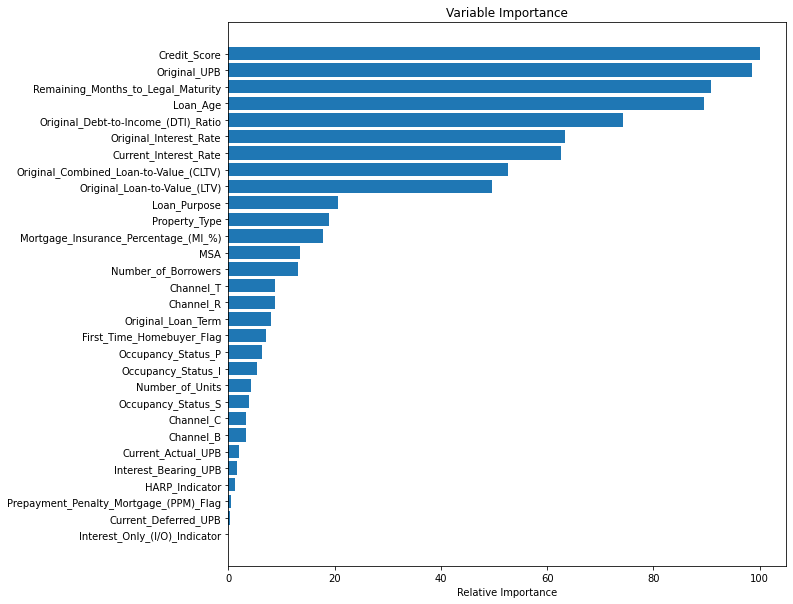

In [706]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### 4.5.2 Random Forest Model using SMOTE to handle imbalanced data<a id='4.5.2_Random_Forest_Model_using_SMOTE_to_handle_imbalanced_data'></a>

In [707]:
from imblearn.over_sampling import SMOTE

In [708]:
features=df_loan.drop(columns=['Loan_Sequence_Number','default_status','Servicer_Name','Property_State','Zero_Balance_Code'],axis=1).columns
X=df_loan[features]
# X=features
y=df_loan['default_status']
oversample=SMOTE()
X,y=oversample.fit_resample(X,y)

In [709]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=5000)

In [710]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [711]:
clf = RandomForestClassifier(n_estimators=10, random_state = 5000,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.989
Random Forest: f1-score=0.989


In [712]:
q=classification_report(y_test,y_pred)
print(q)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    241426
           1       0.99      0.99      0.99    242075

    accuracy                           0.99    483501
   macro avg       0.99      0.99      0.99    483501
weighted avg       0.99      0.99      0.99    483501



Re-implementing Random Forest model below using just a couple of top features identified as important in the feature importance graph.

In [713]:
# features=df_loan.drop(columns=['Loan_Sequence_Number','default_status','Servicer_Name','Property_State'],axis=1).columns
# X=df_loan[features]
X=df_loan[['Credit_Score','Original_Debt-to-Income_(DTI)_Ratio']]
y=df_loan['default_status']
oversample=SMOTE()
X,y=oversample.fit_resample(X,y)

In [714]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=5000)

In [715]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [716]:
clf = RandomForestClassifier(random_state = 5000,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.813
Random Forest: f1-score=0.813


In [717]:
q=classification_report(y_test,y_pred)
print(q)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81    241426
           1       0.81      0.83      0.82    242075

    accuracy                           0.81    483501
   macro avg       0.81      0.81      0.81    483501
weighted avg       0.81      0.81      0.81    483501



In [718]:
ns_probs = [0 for _ in range(len(y_test))]

In [719]:
lr_fpr,lr_tpr,_=roc_curve(y_test,lr_probs)
ns_fpr,ns_tpr,_=roc_curve(y_test,ns_probs)

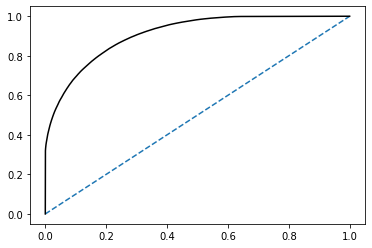

In [720]:
plt.plot(ns_fpr,ns_tpr,linestyle='--')
plt.plot(lr_fpr,lr_tpr,color='black')
plt.show()

## 4.6 Cox model implementation<a id='4.6_Cox_model_implementation'></a>

### 4.6.1 Update target to include loan age/duration feature<a id='4.6.1_Update_target_to_include_loan_age/duration_feature'></a>

In [721]:
def update_duration(default_status,zero_balance_code):
    if default_status==0 and zero_balance_code is None:
        return 2
    

In [722]:
index=df_loan[(df_loan['default_status']==0) & (~df_loan['Zero_Balance_Code'].isnull())].index

In [723]:
index

Int64Index([      0,       1,       2,       4,       5,       6,       7,
                  8,       9,      10,
            ...
            1223553, 1223712, 1223735, 1223854, 1224039, 1224151, 1224157,
            1224291, 1224433, 1224537],
           dtype='int64', length=921430)

In [724]:
df_loan['default_status'].iloc[index]=2

C:\Users\rohan\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [725]:
df_loan['default_status'].value_counts()

2    921430
0    287321
1     16249
Name: default_status, dtype: int64

In [726]:
import lifelines

In [728]:
features=df_loan.drop(columns=['Loan_Sequence_Number','default_status','Loan_Age','Interest_Only_(I/O)_Indicator','Zero_Balance_Code'],axis=1).columns
X=df_loan[features]
# X=features
y=df_loan[['default_status','Loan_Age']]

In [729]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=5000)

In [730]:
def no_defaults(x):
    return (x==0).sum()

In [731]:
new_df=pd.concat([X_train,y_train],axis=1)

In [732]:
servicer_name_default_df=new_df.groupby('Servicer_Name')['default_status'].agg(['sum',no_defaults,'count']).rename(columns={'sum':'defaults'})
servicer_name_default_df['bank_default_rate']=((servicer_name_default_df['defaults']*1.0)/servicer_name_default_df['count'])
servicer_name_default_df.head()
servicer_name_default_rate_df=servicer_name_default_df[['bank_default_rate']]

In [733]:
X_train = X_train.merge(servicer_name_default_rate_df, how='left', right_index=True,left_on='Servicer_Name')
X_train=X_train.drop(columns=['Servicer_Name'])
X_train.head()

,Credit_Score,First_Time_Homebuyer_Flag,Mortgage_Insurance_Percentage_(MI_%),Number_of_Units,Original_Combined_Loan-to-Value_(CLTV),Original_Debt-to-Income_(DTI)_Ratio,Original_UPB,Original_Loan-to-Value_(LTV),Original_Interest_Rate,Prepayment_Penalty_Mortgage_(PPM)_Flag,Property_State,Property_Type,Loan_Purpose,Original_Loan_Term,Number_of_Borrowers,HARP_Indicator,Current_Actual_UPB,Remaining_Months_to_Legal_Maturity,Current_Interest_Rate,Current_Deferred_UPB,Interest_Bearing_UPB,MSA,Occupancy_Status_I,Occupancy_Status_P,Occupancy_Status_S,Channel_B,Channel_C,Channel_R,Channel_T,bank_default_rate
1173721,731,1,0.00,1,80.00,35.00,242000.00,80.00,5.00,0,WI,4,2,360,2,0,237423.82,346,5.00,0.00,237423.82,0,0,1,0,0,0,1,0,1.47
312981,724,0,0.00,1,80.00,46.00,194000.00,80.00,5.50,0,IL,4,1,180,1,0,0.00,89,5.50,0.00,0.00,1,0,1,0,0,0,1,0,1.32
887663,757,0,0.00,1,75.00,25.00,390000.00,75.00,3.62,0,OR,4,0,360,1,0,332559.67,279,3.62,0.00,332559.67,1,0,1,0,0,0,1,0,1.47
1030496,721,0,0.00,1,49.00,50.00,300000.00,49.00,3.62,0,CA,4,1,360,2,0,0.00,357,3.62,0.00,0.00,1,0,1,0,0,0,1,0,1.47
586814,804,0,0.00,1,52.00,45.00,133000.00,52.00,3.88,0,MI,4,1,180,2,1,22479.58,25,3.88,0.00,22479.58,0,0,1,0,0,0,1,0,0.97


In [734]:
state_default_df=new_df.groupby('Property_State')['default_status'].agg(['sum',no_defaults,'count']).rename(columns={'sum':'defaults'})
state_default_df['state_default_rate']=((state_default_df['defaults']*1.0)/state_default_df['count'])
state_default_df.head()
state_default_rate_df=state_default_df[['state_default_rate']]

In [735]:
X_train = X_train.merge(state_default_rate_df, how='left', right_index=True,left_on='Property_State')
X_train=X_train.drop(columns=['Property_State'])
X_train.head()

,Credit_Score,First_Time_Homebuyer_Flag,Mortgage_Insurance_Percentage_(MI_%),Number_of_Units,Original_Combined_Loan-to-Value_(CLTV),Original_Debt-to-Income_(DTI)_Ratio,Original_UPB,Original_Loan-to-Value_(LTV),Original_Interest_Rate,Prepayment_Penalty_Mortgage_(PPM)_Flag,Property_Type,Loan_Purpose,Original_Loan_Term,Number_of_Borrowers,HARP_Indicator,Current_Actual_UPB,Remaining_Months_to_Legal_Maturity,Current_Interest_Rate,Current_Deferred_UPB,Interest_Bearing_UPB,MSA,Occupancy_Status_I,Occupancy_Status_P,Occupancy_Status_S,Channel_B,Channel_C,Channel_R,Channel_T,bank_default_rate,state_default_rate
1173721,731,1,0.00,1,80.00,35.00,242000.00,80.00,5.00,0,4,2,360,2,0,237423.82,346,5.00,0.00,237423.82,0,0,1,0,0,0,1,0,1.47,1.64
312981,724,0,0.00,1,80.00,46.00,194000.00,80.00,5.50,0,4,1,180,1,0,0.00,89,5.50,0.00,0.00,1,0,1,0,0,0,1,0,1.32,1.56
887663,757,0,0.00,1,75.00,25.00,390000.00,75.00,3.62,0,4,0,360,1,0,332559.67,279,3.62,0.00,332559.67,1,0,1,0,0,0,1,0,1.47,1.58
1030496,721,0,0.00,1,49.00,50.00,300000.00,49.00,3.62,0,4,1,360,2,0,0.00,357,3.62,0.00,0.00,1,0,1,0,0,0,1,0,1.47,1.58
586814,804,0,0.00,1,52.00,45.00,133000.00,52.00,3.88,0,4,1,180,2,1,22479.58,25,3.88,0.00,22479.58,0,0,1,0,0,0,1,0,0.97,1.55


In [736]:
X_test = X_test.merge(servicer_name_default_rate_df, how='left', right_index=True,left_on='Servicer_Name')
X_test=X_test.drop(columns=['Servicer_Name'])
X_test.head()

,Credit_Score,First_Time_Homebuyer_Flag,Mortgage_Insurance_Percentage_(MI_%),Number_of_Units,Original_Combined_Loan-to-Value_(CLTV),Original_Debt-to-Income_(DTI)_Ratio,Original_UPB,Original_Loan-to-Value_(LTV),Original_Interest_Rate,Prepayment_Penalty_Mortgage_(PPM)_Flag,Property_State,Property_Type,Loan_Purpose,Original_Loan_Term,Number_of_Borrowers,HARP_Indicator,Current_Actual_UPB,Remaining_Months_to_Legal_Maturity,Current_Interest_Rate,Current_Deferred_UPB,Interest_Bearing_UPB,MSA,Occupancy_Status_I,Occupancy_Status_P,Occupancy_Status_S,Channel_B,Channel_C,Channel_R,Channel_T,bank_default_rate
372454,746,0,0.00,2,72.00,48.00,335000.00,72.00,6.62,0,CA,4,0,360,1,0,0.00,328,6.62,0.00,0.00,1,0,1,0,0,0,0,1,1.69
398158,704,0,0.00,1,70.00,25.00,270000.00,70.00,5.88,0,LA,4,0,360,1,0,0.00,288,5.88,0.00,0.00,1,0,1,0,0,0,0,1,1.97
984365,679,0,0.00,1,79.00,35.00,422000.00,79.00,5.50,0,TN,4,1,360,1,0,0.00,337,5.50,0.00,0.00,1,0,1,0,0,0,1,0,0.55
780854,714,0,0.00,1,96.00,45.00,187000.00,96.00,4.00,0,IL,4,1,180,1,1,0.00,91,4.00,0.00,0.00,1,0,1,0,0,0,1,0,0.87
438520,791,1,0.00,1,36.00,39.00,150000.00,36.00,6.38,0,CA,0,2,360,2,0,0.00,339,6.38,0.00,0.00,0,0,1,0,0,0,0,1,1.69


In [737]:
X_test = X_test.merge(state_default_rate_df, how='left', right_index=True,left_on='Property_State')
X_test=X_test.drop(columns=['Property_State'])
X_test.head()

,Credit_Score,First_Time_Homebuyer_Flag,Mortgage_Insurance_Percentage_(MI_%),Number_of_Units,Original_Combined_Loan-to-Value_(CLTV),Original_Debt-to-Income_(DTI)_Ratio,Original_UPB,Original_Loan-to-Value_(LTV),Original_Interest_Rate,Prepayment_Penalty_Mortgage_(PPM)_Flag,Property_Type,Loan_Purpose,Original_Loan_Term,Number_of_Borrowers,HARP_Indicator,Current_Actual_UPB,Remaining_Months_to_Legal_Maturity,Current_Interest_Rate,Current_Deferred_UPB,Interest_Bearing_UPB,MSA,Occupancy_Status_I,Occupancy_Status_P,Occupancy_Status_S,Channel_B,Channel_C,Channel_R,Channel_T,bank_default_rate,state_default_rate
372454,746,0,0.00,2,72.00,48.00,335000.00,72.00,6.62,0,4,0,360,1,0,0.00,328,6.62,0.00,0.00,1,0,1,0,0,0,0,1,1.69,1.58
398158,704,0,0.00,1,70.00,25.00,270000.00,70.00,5.88,0,4,0,360,1,0,0.00,288,5.88,0.00,0.00,1,0,1,0,0,0,0,1,1.97,1.40
984365,679,0,0.00,1,79.00,35.00,422000.00,79.00,5.50,0,4,1,360,1,0,0.00,337,5.50,0.00,0.00,1,0,1,0,0,0,1,0,0.55,1.46
780854,714,0,0.00,1,96.00,45.00,187000.00,96.00,4.00,0,4,1,180,1,1,0.00,91,4.00,0.00,0.00,1,0,1,0,0,0,1,0,0.87,1.56
438520,791,1,0.00,1,36.00,39.00,150000.00,36.00,6.38,0,0,2,360,2,0,0.00,339,6.38,0.00,0.00,0,0,1,0,0,0,0,1,1.69,1.58


In [738]:
new_df=pd.concat([X_train,y_train],axis=1)

In [739]:
new_df.head()

,Credit_Score,First_Time_Homebuyer_Flag,Mortgage_Insurance_Percentage_(MI_%),Number_of_Units,Original_Combined_Loan-to-Value_(CLTV),Original_Debt-to-Income_(DTI)_Ratio,Original_UPB,Original_Loan-to-Value_(LTV),Original_Interest_Rate,Prepayment_Penalty_Mortgage_(PPM)_Flag,Property_Type,Loan_Purpose,Original_Loan_Term,Number_of_Borrowers,HARP_Indicator,Current_Actual_UPB,Remaining_Months_to_Legal_Maturity,Current_Interest_Rate,Current_Deferred_UPB,Interest_Bearing_UPB,MSA,Occupancy_Status_I,Occupancy_Status_P,Occupancy_Status_S,Channel_B,Channel_C,Channel_R,Channel_T,bank_default_rate,state_default_rate,default_status,Loan_Age
1173721,731,1,0.00,1,80.00,35.00,242000.00,80.00,5.00,0,4,2,360,2,0,237423.82,346,5.00,0.00,237423.82,0,0,1,0,0,0,1,0,1.47,1.64,0,14
312981,724,0,0.00,1,80.00,46.00,194000.00,80.00,5.50,0,4,1,180,1,0,0.00,89,5.50,0.00,0.00,1,0,1,0,0,0,1,0,1.32,1.56,2,91
887663,757,0,0.00,1,75.00,25.00,390000.00,75.00,3.62,0,4,0,360,1,0,332559.67,279,3.62,0.00,332559.67,1,0,1,0,0,0,1,0,1.47,1.58,0,81
1030496,721,0,0.00,1,49.00,50.00,300000.00,49.00,3.62,0,4,1,360,2,0,0.00,357,3.62,0.00,0.00,1,0,1,0,0,0,1,0,1.47,1.58,2,3
586814,804,0,0.00,1,52.00,45.00,133000.00,52.00,3.88,0,4,1,180,2,1,22479.58,25,3.88,0.00,22479.58,0,0,1,0,0,0,1,0,0.97,1.55,0,155


### 4.6.2 Cox model<a id='4.6.2_Cox_model'></a>

In [740]:
from lifelines import CoxPHFitter
cph=CoxPHFitter(penalizer=0.1,baseline_estimation_method='breslow')
cph.fit(new_df,duration_col='Loan_Age',event_col='default_status')

<lifelines.CoxPHFitter: fitted with 980000 total observations, 229761 right-censored observations>

In [741]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 980000 total observations, 229761 right-censored observations>
             duration col = 'Loan_Age'
                event col = 'default_status'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 980000
number of events observed = 750239
   partial log-likelihood = -9300500.94
         time fit was run = 2024-03-07 19:20:54 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
Credit_Score                             0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
First_Time_Homebuyer_Flag               -0.03       0.97       0.00            -0.03            -0.02                 0.97                 0.98
Mortgage_Insurance_Percentage_(MI_%)     0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
Number_of_Units                         -0.10       0.90       0.01            -0.11            -0.09                 0.89                 0.91
Original_Combined_Loan-to-Value_(CLTV)  -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Original_Debt-to-Income_(DTI)_Ratio     -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Original_UPB                             0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
Original_Loan-to-Value_(LTV)            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Original_Interest_Rate                  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
Prepayment_Penalty_Mortgage_(PPM)_Flag  -0.28       0.75       0.03            -0.34            -0.23                 0.71                 0.80
Property_Type                           -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
Loan_Purpose                             0.05       1.05       0.00             0.04             0.05                 1.04                 1.05
Original_Loan_Term                      -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
Number_of_Borrowers                      0.04       1.04       0.00             0.04             0.04                 1.04                 1.04
HARP_Indicator                          -0.16       0.85       0.00            -0.17            -0.15                 0.84                 0.86
Current_Actual_UPB                      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Remaining_Months_to_Legal_Maturity       0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
Current_Interest_Rate                    0.13       1.14       0.00             0.13             0.14                 1.14                 1.15
Current_Deferred_UPB                    -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
Interest_Bearing_UPB                    -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
MSA                                     -0.11       0.90       0.00            -0.11            -0.10                 0.89                 0.90
Occupancy_Status_I                      -0.04       0.96       0.01            -0.05            -0.02                 0.95                 0.98
Occupancy_Status_P                       0.05       1.05       0.01             0.04          

In [742]:
cph.baseline_survival_

,baseline survival
0.00,1.00
1.00,1.00
2.00,1.00
3.00,0.99
4.00,0.99
...,...
291.00,0.00
292.00,0.00
293.00,0.00
294.00,0.00


In [743]:
cph.baseline_hazard_.max()

baseline hazard   1.14
dtype: float64

In [744]:
cph_score=cph.score(new_df,scoring_method='concordance_index')

In [745]:
cph_score

0.8532192079072548

In [746]:
from lifelines.utils import concordance_index

In [826]:
y_pred=cph.predict_expectation(X_test)

In [827]:
y_pred=np.array(y_pred)

In [828]:
features=X_test.values
coefficients=np.array(cph.summary['coef'])
outcome=np.dot(features,coefficients)
outcome=np.array(outcome)
outcome_exp=np.exp(outcome)

In [829]:
q=cph.baseline_hazard_
h=np.array(q['baseline hazard'])

In [830]:
from scipy import interpolate
probs=[]
for i in range(0,len(y_pred)):
    x=y_pred[i]
    q=interpolate.interp1d([int(np.floor(x)),int(np.ceil(x))],[h[int(np.floor(x))],h[int(np.ceil(x))]],kind='linear')
    probs.append(q(x)*outcome_exp[i])

In [831]:
c_index=concordance_index(y_test['Loan_Age'],y_pred,y_test['default_status'])

In [832]:
c_index

0.8529835962704657

In [833]:
prob_df=pd.DataFrame(probs,columns=['hazard_ratios'])

In [834]:
conc_df=pd.concat([y_test['Loan_Age'].reset_index(),prob_df],axis=1).drop(columns=['index'])

In [835]:
conc_df=pd.concat([conc_df,y_test['default_status'].reset_index()],axis=1).drop(columns=['index'])

In [836]:
y_pred_df=pd.DataFrame(y_pred,columns=['survival_age'])

In [837]:
conc_df=pd.concat([conc_df,y_pred_df['survival_age']],axis=1)
conc_df.head()

,Loan_Age,hazard_ratios,default_status,survival_age
0,32,0.83,1,32.37
1,72,0.53,2,48.92
2,23,0.71,2,36.72
3,89,0.31,2,97.84
4,21,1.05,2,26.51


In [838]:
conc_df=pd.concat([conc_df,X_test[['Remaining_Months_to_Legal_Maturity','Original_Loan_Term']].reset_index()],axis=1).drop(columns=['index'])
conc_df.head()

,Loan_Age,hazard_ratios,default_status,survival_age,Remaining_Months_to_Legal_Maturity,Original_Loan_Term
0,32,0.83,1,32.37,328,360
1,72,0.53,2,48.92,288,360
2,23,0.71,2,36.72,337,360
3,89,0.31,2,97.84,91,180
4,21,1.05,2,26.51,339,360


<AxesSubplot:>

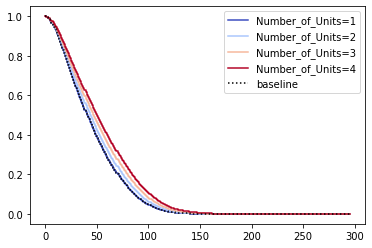

In [839]:
cph.plot_partial_effects_on_outcome(covariates='Number_of_Units', values=[1,2,3,4], cmap='coolwarm')

<Figure size 1080x864 with 0 Axes>

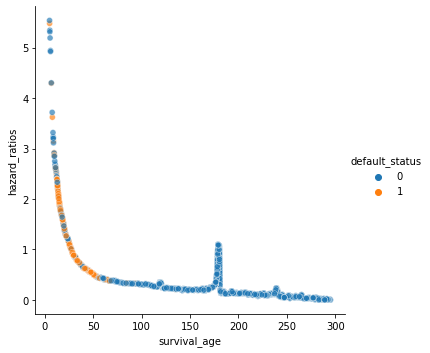

In [840]:
plt.figure(figsize=(15,12))
def_ong_df=conc_df[conc_df['default_status'].isin([0,1])]
order=[0,1]
ax=sns.relplot(data=def_ong_df,x='survival_age',y='hazard_ratios',kind='scatter',hue=def_ong_df['default_status'],hue_order=order,alpha=0.66)


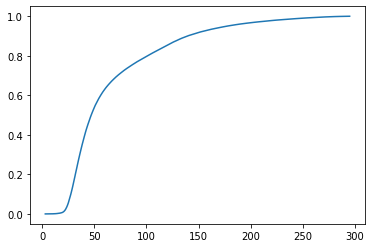

In [841]:
surv_age=np.sort(conc_df['survival_age'])
n=len(surv_age)
proportion=np.arange(1,n+1)/n
sns.lineplot(x=surv_age, y=proportion)
plt.show()

In [842]:
median=np.quantile(surv_age,0.5)

In [843]:
median

47.10723357938508

### 4.6.3 Cox model with scaled data<a id='4.6.3_Cox_model_with_scaled_data'></a>

In [763]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [764]:
X_train_scaled=pd.DataFrame(X_train_scaled,columns=X_train.columns)
X_test_scaled=pd.DataFrame(X_test_scaled,columns=X_test.columns)

In [765]:
new_df=pd.concat([X_train_scaled,y_train.reset_index()],axis=1).drop(columns=['index'])

In [766]:
new_df.head()

,Credit_Score,First_Time_Homebuyer_Flag,Mortgage_Insurance_Percentage_(MI_%),Number_of_Units,Original_Combined_Loan-to-Value_(CLTV),Original_Debt-to-Income_(DTI)_Ratio,Original_UPB,Original_Loan-to-Value_(LTV),Original_Interest_Rate,Prepayment_Penalty_Mortgage_(PPM)_Flag,Property_Type,Loan_Purpose,Original_Loan_Term,Number_of_Borrowers,HARP_Indicator,Current_Actual_UPB,Remaining_Months_to_Legal_Maturity,Current_Interest_Rate,Current_Deferred_UPB,Interest_Bearing_UPB,MSA,Occupancy_Status_I,Occupancy_Status_P,Occupancy_Status_S,Channel_B,Channel_C,Channel_R,Channel_T,bank_default_rate,state_default_rate,default_status,Loan_Age
0,-0.19,2.58,-0.47,-0.13,0.37,-0.00,0.31,0.44,-0.10,-0.03,0.47,1.06,0.60,0.88,-0.27,1.66,0.88,-0.09,-0.05,1.66,-1.88,-0.26,0.33,-0.20,-0.27,-0.47,0.90,-0.49,-0.11,1.99,0,14
1,-0.32,-0.39,-0.47,-0.13,0.37,0.96,-0.08,0.44,0.25,-0.03,0.47,-0.20,-1.74,-1.11,-0.27,-0.43,-1.85,0.26,-0.05,-0.43,0.53,-0.26,0.33,-0.20,-0.27,-0.47,0.90,-0.49,-0.49,0.63,2,91
2,0.31,-0.39,-0.47,-0.13,0.11,-0.87,1.52,0.18,-1.07,-0.03,0.47,-1.47,0.60,-1.11,-0.27,2.49,0.16,-1.05,-0.05,2.50,0.53,-0.26,0.33,-0.20,-0.27,-0.47,0.90,-0.49,-0.11,0.96,0,81
3,-0.38,-0.39,-0.47,-0.13,-1.22,1.31,0.78,-1.20,-1.07,-0.03,0.47,-0.20,0.60,0.88,-0.27,-0.43,0.99,-1.05,-0.05,-0.43,0.53,-0.26,0.33,-0.20,-0.27,-0.47,0.90,-0.49,-0.11,0.99,2,3
4,1.21,-0.39,-0.47,-0.13,-1.07,0.87,-0.58,-1.04,-0.89,-0.03,0.47,-0.20,-1.74,0.88,3.69,-0.23,-2.53,-0.88,-0.05,-0.23,-1.88,-0.26,0.33,-0.20,-0.27,-0.47,0.90,-0.49,-1.34,0.48,0,155


In [767]:
from lifelines import CoxPHFitter
cph1=CoxPHFitter(penalizer=0.1,baseline_estimation_method='breslow')
cph1.fit(new_df,duration_col='Loan_Age',event_col='default_status')

<lifelines.CoxPHFitter: fitted with 980000 total observations, 229761 right-censored observations>

In [768]:
cph1.print_summary()

<lifelines.CoxPHFitter: fitted with 980000 total observations, 229761 right-censored observations>
             duration col = 'Loan_Age'
                event col = 'default_status'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 980000
number of events observed = 750239
   partial log-likelihood = -9300500.94
         time fit was run = 2024-03-07 19:24:25 UTC

---
                                         coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                      
Credit_Score                             0.05       1.05       0.00             0.05             0.05                 1.05                 1.06
First_Time_Homebuyer_Flag               -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
Mortgage_Insurance_Percentage_(MI_%)     0.02       1.02       0.00             0.01             0.02                 1.01                 1.02
Number_of_Units                         -0.02       0.98       0.00            -0.03            -0.02                 0.98                 0.98
Original_Combined_Loan-to-Value_(CLTV)  -0.04       0.96       0.00            -0.04            -0.03                 0.96                 0.97
Original_Debt-to-Income_(DTI)_Ratio     -0.02       0.98       0.00            -0.02            -0.01                 0.98                 0.99
Original_UPB                             0.18       1.20       0.00             0.18             0.19                 1.20                 1.20
Original_Loan-to-Value_(LTV)            -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
Original_Interest_Rate                  -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
Prepayment_Penalty_Mortgage_(PPM)_Flag  -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
Property_Type                           -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
Loan_Purpose                             0.04       1.04       0.00             0.03             0.04                 1.03                 1.04
Original_Loan_Term                      -0.75       0.47       0.00            -0.76            -0.75                 0.47                 0.47
Number_of_Borrowers                      0.02       1.02       0.00             0.02             0.02                 1.02                 1.02
HARP_Indicator                          -0.04       0.96       0.00            -0.04            -0.04                 0.96                 0.96
Current_Actual_UPB                      -0.52       0.59       0.00            -0.53            -0.52                 0.59                 0.60
Remaining_Months_to_Legal_Maturity       1.14       3.12       0.00             1.13             1.14                 3.11                 3.13
Current_Interest_Rate                    0.19       1.21       0.00             0.19             0.19                 1.20                 1.21
Current_Deferred_UPB                    -0.04       0.97       0.00            -0.04            -0.03                 0.96                 0.97
Interest_Bearing_UPB                    -0.52       0.59       0.00            -0.53            -0.52                 0.59                 0.60
MSA                                     -0.04       0.96       0.00            -0.05            -0.04                 0.95                 0.96
Occupancy_Status_I                      -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
Occupancy_Status_P                       0.02       1.02       0.00             0.01          

In [769]:
cph1.baseline_survival_

,baseline survival
0.00,1.00
1.00,1.00
2.00,1.00
3.00,0.99
4.00,0.99
...,...
291.00,0.00
292.00,0.00
293.00,0.00
294.00,0.00


In [770]:
cph1.baseline_hazard_.max()

baseline hazard   1.14
dtype: float64

In [771]:
cph_score=cph1.score(new_df,scoring_method='concordance_index')

In [772]:
cph_score

0.8532192079072548

In [773]:
from lifelines.utils import concordance_index

In [774]:
y_pred=cph1.predict_expectation(X_test_scaled)

In [800]:
y_pred=np.array(y_pred)

In [801]:
features=X_test_scaled.values
coefficients=np.array(cph1.summary['coef'])
outcome=np.dot(features,coefficients)
outcome=np.array(outcome)
outcome_exp=np.exp(outcome)

In [802]:
q=cph1.baseline_hazard_
h=np.array(q['baseline hazard'])

In [803]:
from scipy import interpolate
probs=[]
for i in range(0,len(y_pred)):
    x=y_pred[i]
    q=interpolate.interp1d([int(np.floor(x)),int(np.ceil(x))],[h[int(np.floor(x))],h[int(np.ceil(x))]],kind='linear')
    probs.append(q(x)*outcome_exp[i])

In [804]:
c_index=concordance_index(y_test['Loan_Age'],y_pred,y_test['default_status'])

In [805]:
c_index

0.8529835962704657

In [806]:
prob_df=pd.DataFrame(probs,columns=['hazard_ratios'])

In [807]:
conc_df=pd.concat([y_test['Loan_Age'].reset_index(),prob_df],axis=1).drop(columns=['index'])

In [808]:
conc_df=pd.concat([conc_df,y_test['default_status'].reset_index()],axis=1).drop(columns=['index'])

In [809]:
y_pred_df=pd.DataFrame(y_pred,columns=['survival_age'])

In [810]:
conc_df=pd.concat([conc_df,y_pred_df['survival_age']],axis=1)
conc_df.head()

,Loan_Age,hazard_ratios,default_status,survival_age
0,32,0.04,1,32.37
1,72,0.02,2,48.92
2,23,0.03,2,36.72
3,89,0.01,2,97.84
4,21,0.05,2,26.51


In [811]:
conc_df=pd.concat([conc_df,X_test[['Remaining_Months_to_Legal_Maturity','Original_Loan_Term']].reset_index()],axis=1).drop(columns=['index'])
conc_df.head()

,Loan_Age,hazard_ratios,default_status,survival_age,Remaining_Months_to_Legal_Maturity,Original_Loan_Term
0,32,0.04,1,32.37,328,360
1,72,0.02,2,48.92,288,360
2,23,0.03,2,36.72,337,360
3,89,0.01,2,97.84,91,180
4,21,0.05,2,26.51,339,360


<Figure size 1080x864 with 0 Axes>

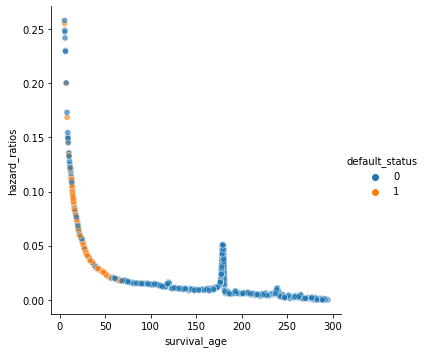

In [812]:
plt.figure(figsize=(15,12))
def_ong_df=conc_df[conc_df['default_status'].isin([0,1])]
order=[0,1]
ax=sns.relplot(data=def_ong_df,x='survival_age',y='hazard_ratios',kind='scatter',hue=def_ong_df['default_status'],hue_order=order,alpha=0.66)


In [817]:
print(X_test_scaled['Credit_Score'].max(),X_test_scaled['Credit_Score'].min(),np.median(X_test_scaled['Credit_Score']))

1.9579266274324796 -8.439254539007917 0.1963416047574952


<AxesSubplot:>

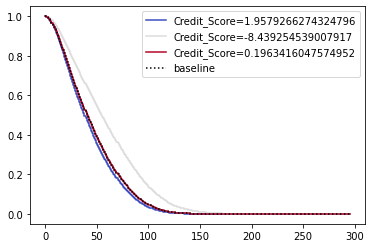

In [818]:
cph1.plot_partial_effects_on_outcome(covariates='Credit_Score', values=[1.9579266274324796,-8.439254539007917,0.1963416047574952
], cmap='coolwarm')

<AxesSubplot:>

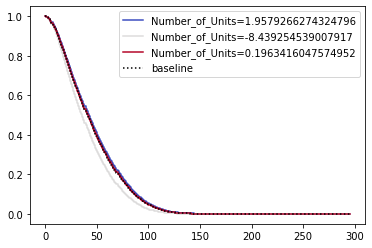

In [819]:
cph1.plot_partial_effects_on_outcome(covariates='Number_of_Units', values=[1.9579266274324796,-8.439254539007917,0.1963416047574952], cmap='coolwarm')

<AxesSubplot:>

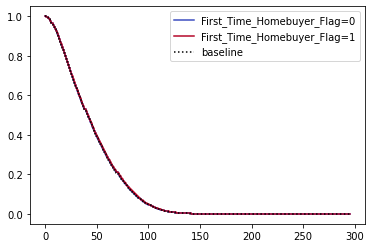

In [820]:
cph1.plot_partial_effects_on_outcome(covariates='First_Time_Homebuyer_Flag', values=[0,1], cmap='coolwarm')

In [821]:
print(X_test_scaled['Remaining_Months_to_Legal_Maturity'].max(),X_test_scaled['Remaining_Months_to_Legal_Maturity'].min(),np.median(X_test_scaled['Remaining_Months_to_Legal_Maturity']))

2.2993565628863126 -2.9068141683775908 0.4293850349221351


<AxesSubplot:>

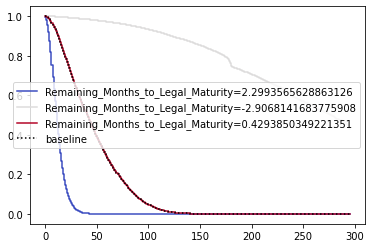

In [822]:
cph1.plot_partial_effects_on_outcome(covariates='Remaining_Months_to_Legal_Maturity', values=[2.2993565628863126,-2.9068141683775908,0.4293850349221351], cmap='coolwarm')

In [823]:
print(X_test_scaled['Original_UPB'].max(),X_test_scaled['Original_UPB'].min(),np.median(X_test_scaled['Original_UPB']))

9.264587393496022 -1.5836195812489122 -0.23778939265273627


<AxesSubplot:>

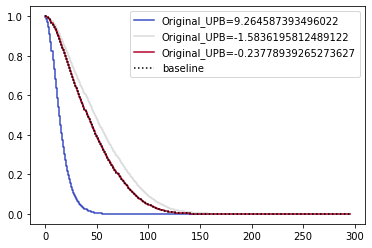

In [824]:
cph1.plot_partial_effects_on_outcome(covariates='Original_UPB', values=[9.264587393496022,-1.5836195812489122,-0.23778939265273627
], cmap='coolwarm')

Writing out the clean preprocessed loan data file to be used as part of model pipeline in the modeling step.

In [844]:
df_loan.to_csv('../data/processed/df_loan_preprocess_features.txt',sep="|")

## 4.7 Setup model pipeline<a id='4.7_Setup_model_pipeline'></a>

Setting up the model pipeline, any additional model evaluation and hyperparameter tuning will be done in the next modeling step.

## 4.8 Summary<a id='4.8_Summary'></a>

Preprocessed the data and computed relevant features. Split the data into train and test. Tested couple of models (both Standard Classification and Cox survival) using scaled and non-scaled versions of the data to get an estimate of model performance and feature importance. 

Ran the random forest model on the train data. Given the data is imbalanced (positive class i.e loan defaults is in the minority with an imbalance ratio 99:1), will consider recall and f1 score metrics to evaluate the model. The model evaluation metrics suggested that the model is not doing too well in identifying the positive class i.e. loan defaults (precision 0.47, recall 0.02, f1 score 0.05). Tested SMOTE technique to balance the data and reran random forest model. The model evaluation metrics for the positive class i.e loan defaults now showed overfitting (precision 0.99, recall 0.99, f1 score 0.99).

Continued further to test the Cox survival model since the loan default prediction problem is akin to a survival analysis problem given that the loan default event of interest is a time-based event. Based on the results of the Cox model, the model estimates for the coefficients using the unscaled data appear to be valid when plotting the 'partial effects on outcome', 'survival curve', and 'ecdf' graphs. The concordance-index (model-performance metric) of 0.853 appears reasonable.

Hence will continue with the cox model implementation in the next modeling step.
Setting up the model pipeline, any additional model evaluation and hyperparameter tuning will be done in the next modeling step.